# What is torch.nn really ?

Source :https://pytorch.org/tutorials/beginner/nn_tutorial.html


PyTorch provides the elegantly designed modules and classes `torch.nn , torch.optim , Dataset , and DataLoader` to help you create and train neural networks. In order to fully utilize their power and customize them for your problem, you need to really understand exactly what they’re doing. To develop this understanding, we will first train basic neural net on the `MNIST` data set without using any features from these models; we will initially only use the most basic PyTorch tensor functionality. Then, we will incrementally add one feature from `torch.nn, torch.optim, Dataset, or DataLoader` at a time, showing exactly what each piece does, and how it works to make the code either more concise, or more flexible.

## MNIST data setup
We will use the classic MNIST dataset, which consists of black-and-white images of hand-drawn digits (between 0 and 9).


We will use **pathlib** for dealing with paths (part of the Python 3 standard library), and will download the dataset using requests. We will only import modules when we use them, so you can see exactly what’s being used at each point.



In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH/ "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not(PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

The datasets is numpy array format, and has been stored using **pickle** - a python-spwcific format for serializing data

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)


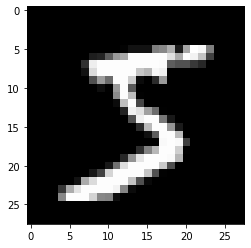

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
print(x_train.shape)

In [4]:
import torch

#Convert numpy array to torch.tensor
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## Neural net from scratch (no torch.nn)

First create a model using nothing but PyTorch tensor operations. We’re assuming you’re already familiar with the basics of neural networks.
PyTorch provides methods to create random or zero-filled tensors, which we will use to create our weights and bias for a simple linear model

For the `weights`, we set `requires_grad` after the initialization, since we don’t want that step included in the gradient. (Note that a trailling `_` in PyTorch signifies that the operation is performed in-place.)

_We are initializing the `weights` here with Xavier initialisation (by multiplying with `1/sqrt(n))`._

In [5]:
import math
weights = torch.randn(784, 10)/math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [6]:
weights

tensor([[-0.0578,  0.0234,  0.0176,  ...,  0.0233,  0.0652, -0.0283],
        [-0.0688,  0.0313, -0.0114,  ..., -0.0190,  0.0184,  0.0040],
        [ 0.0282, -0.0181, -0.0125,  ..., -0.0164, -0.0053, -0.0389],
        ...,
        [-0.0701,  0.0852,  0.0148,  ..., -0.0265, -0.0253, -0.0082],
        [ 0.0094, -0.0663, -0.0323,  ..., -0.0355, -0.0366, -0.0048],
        [-0.0469, -0.0528,  0.0325,  ...,  0.0257, -0.0058, -0.0093]],
       requires_grad=True)

In [7]:
bias

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

PyTorch’s ability to calculate gradients automatically, we can use any standard Python function (or callable object) as a model!So let’s just write a plain matrix multiplication and broadcasted addition to create a simple linear model. We also need an activation function, so we’ll write log_softmax and use it. 

In [8]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)
    
def model(xb):
    return log_softmax(xb @ weights + bias)

In the above, the `@` stands for the dot product operation.

We will call our function on one batch of data (in this case, 64 images). This is one forward pass. Note that our predictions won’t be any better than random at this stage, since we start with random weights

In [9]:
bs = 64

xb = x_train[0:bs] # a mini-batch from x
preds = model(xb) #predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.9251, -2.4115, -1.7890, -2.8351, -2.6138, -2.5317, -1.5779, -2.3377,
        -2.4624, -2.4096], grad_fn=<SelectBackward>) torch.Size([64, 10])


As you see, the preds tensor contains not only the tensor values, but also a gradient function. We’ll use this later to do backprop.

Let’s implement negative log-likelihood to use as the loss function (again, we can just use standard Python):

In [10]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

Let’s check our loss with our random model, so we can see if we improve after a backprop pass later.

In [11]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.4039, grad_fn=<NegBackward>)


Let’s also implement a function to calculate the accuracy of our model. For each prediction, if the index with the largest value matches the target value, then the prediction was correct.

In [12]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds==yb).float().mean()

In [13]:
print(accuracy(preds, yb))

tensor(0.0469)


We can now run a training loop. For each iteration, we will:

- select a mini-batch of data (of size `bs`)
- use the model to make predictions
- calculate the `loss`
- `loss.backward()` updates the gradients of the model, in this case, `weights` and `bias`

We now use these gradients to update the weights and bias. We do this within the `torch.no_grad()` context manager, because we do not want these actions to be recorded for our next calculation of the gradient

We then set the gradients to zero, so that we are ready for the next loop. Otherwise, our gradients would record a running tally of all the operations that had happened (i.e. `loss.backward()` adds the gradients to whatever is already stored, rather than replacing them).



In [14]:
from IPython.core.debugger import set_trace

lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        #set trace()
        start_i = i * bs
        end_i = start_i * bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad*lr
            bias -= bias.grad*lr
            weights.grad.zero_()
            bias.grad.zero_()

That’s it: we’ve created and trained a minimal neural network (in this case, a logistic regression, since we have no hidden layers) entirely from scratch!

Let’s check the loss and accuracy and compare those to what we got earlier. We expect that the loss will have decreased and accuracy to have increased, and they have.

In [15]:
print(loss_func(model(xb), yb))
print(accuracy(model(xb), yb))

tensor(0.0472, grad_fn=<NegBackward>)
tensor(1.)


## Using torch.nn.functional

In [16]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

Note that we no longer call `log_softmax` in the `model` function. Let’s confirm that our loss and accuracy are the same as before:

In [17]:
print(loss_func(model(xb), yb))
print(accuracy(model(xb), yb))

tensor(0.0472, grad_fn=<NllLossBackward>)
tensor(1.)


## Refactor using nn.Module

Next up, we’ll use `nn.Module` and `nn.Parameter`, for a clearer and more concise training loop. We subclass nn.Module (which itself is a class and able to keep track of state). In this case, we want to create a class that holds our weights, bias, and method for the forward step. `nn.Module` has a number of attributes and methods (such as `.parameters()` and `.zero_grad()`) which we will be using.

In [18]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10)/math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [19]:
model = Mnist_Logistic()

In [20]:
print(loss_func(model(xb), yb))

tensor(2.4683, grad_fn=<NllLossBackward>)


Previously for our training loop we had to update the values for each parameter by name, and manually zero out the grads for each parameter separately, like this:

In [21]:
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()

Now we can take advantage of `model.parameters()` and `model.zero_grad()` (which are both defined by PyTorch for `nn.Module`) to make those steps more concise and less rone to the error of forgetting some of our parameters particularly if we had a more complicated model:

In [22]:
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [23]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1) // bs + 1):
            start_i = i*bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad*lr
                model.zero_grad()

In [24]:
fit()

## Refactor using nn.Linear

We continue to refactor our code. Instead of manually defining and initializing self.weights and self.bias, and calculating `xb  @ self.weights + self.bias`, we will instead use the Pytorch class `nn.Linear` for a linear layer, which does all that for us. Pytorch has many types of predefined layers that can greatly simplify our code, and often makes it faster too.

In [25]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self, xb):
        return self.lin(xb)

In [26]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3002, grad_fn=<NllLossBackward>)


In [27]:
fit()
print(loss_func(model(xb), yb))

tensor(0.0801, grad_fn=<NllLossBackward>)


## Refactor using optim

Pytorch also has a package with various optimization algorithms, `torch.optim`. We can use the step method from our optimizer to take a forward step, instead of manually updating each parameter.

In [28]:
with torch.no_grad():
    for p in model.parameters(): p -= p.grad*lr
    model.zero_grad()

In [29]:
from torch import optim

opt = optim.SGD(model.parameters(), lr=lr)

opt.step()
opt.zero_grad()

In [30]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

tensor(2.3605, grad_fn=<NllLossBackward>)


In [31]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(0.0827, grad_fn=<NllLossBackward>)


## REfactor using Dataset

PyTorch has an abstract Dataset class. A Dataset can be anything that has a `__len__` function (called by Python’s standard len function) and a `__getitem__` function as a way of indexing into it. This tutorial walks through a nice example of creating a custom FacialLandmarkDataset class as a subclass of `Dataset`.

PyTorch’s TensorDataset is a Dataset wrapping tensors. By defining a length and way of indexing, this also gives us a way to iterate, index, and slice along the first dimension of a tensor. This will make it easier to access both the independent and dependent variables in the same line as we train.

In [32]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)

model, opt = get_model()

for epoch in range(epochs):
    for i in range((n-1)//bs+1):
        xb, yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(0.0815, grad_fn=<NllLossBackward>)


## Refactor using DataLoader

Pytorch’s `DataLoader` is responsible for managing batches. You can create a `DataLoader` from any `Dataset`. `DataLoader` makes it easier to iterate over batches. Rather than having to use `train_ds[i*bs : i*bs+bs]`, the `DataLoader` gives us each minibatch automatically

In [33]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))
    

tensor(0.0801, grad_fn=<NllLossBackward>)


## Add validation

In section 1, we were just trying to get a reasonable training loop set up for use on our training data. In reality, you always should also have a validation set, in order to identify if you are overfitting.

Shuffling the training data is important to prevent correlation between batches and overfitting. On the other hand, the validation loss will be identical whether we shuffle the validation set or not. Since shuffling takes extra time, it makes no sense to shuffle the validation data.

We’ll use a batch size for the validation set that is twice as large as that for the training set. This is because the validation set does not need backpropagation and thus takes less memory (it doesn’t need to store the gradients). We take advantage of this to use a larger batch size and compute the loss more quickly.

In [35]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs*2)

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [36]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
        
    print(epoch, valid_loss/len(valid_dl))

0 tensor(0.3213)
1 tensor(0.2838)


## Create fit() and get_data()



In [37]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

`fit` runs the necessary operations to train our model and compute the training and validation losses for each epoch.

In [38]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
            
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
            *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)/np.sum(nums))
        
        print(epoch, val_loss)
        
        
        
        

`get_data` returns dataloaders for the training and validation sets.

In [39]:
def get_data(train_ds, valid_ds, bs):
    return(
            DataLoader(train_ds, batch_size=bs, shuffle=True),
            DataLoader(valid_ds, batch_size=2*bs),
    )

In [40]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3016978845596314
1 0.2845732496857643


## Switch to CNN

We are now going to build our neural network with three convolutional layers. Because none of the functions in the previous section assume anything about the model form, we’ll be able to use them to train a CNN without any modification.

We will use Pytorch’s predefined `Conv2d` class as our convolutional layer. We define a CNN with 3 convolutional layers. Each convolution is followed by a ReLU. At the end, we perform an average pooling. (Note that `view` is PyTorch’s version of numpy’s `reshape`)

In [41]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, xb):
        xb = xb.view(-1,1,28,28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))
    
    lr = 0.1

In [43]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.28017572860717777
1 0.2969410479307175


## nn.Sequential

`torch.nn` has another handy class we can use to simply our code: `Sequential` . A `Sequential` object runs each of the modules contained within it, in a sequential manner. This is a simpler way of writing our neural network.

To take advantage of this, we need to be able to easily define a **custom** layer from a given function. For instance, PyTorch doesn’t have a view layer, and we need to create one for our network. `Lambda` will create a layer that we can then use when defining a network with `Sequential`.

In [44]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
    
def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [51]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

In [52]:
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.798557537651062
1 0.7389464785575864


## Wrapping DatLoader

Our CNN is fairly concise, but it only works with MNIST, because:
- It assumes the input is a 28*28 long vector
- It assumes that the final CNN grid size is 4*4 (since that’s the average pooling kernel size we used)

Let’s get rid of these two assumptions, so our model works with any 2d single channel image. First, we can remove the initial Lambda layer but moving the data preprocessing into a generator:


In [58]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield(self.func(*b))

In [59]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

Next, we can replace `nn.AvgPool2d` with `nn.AdaptiveAvgPool2d`, which allows us to define the size of the output tensor we want, rather than the input tensor we have. As a result, our model will work with any size input.

In [60]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

In [61]:
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [62]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.34977263078689574
1 0.2623179137945175


## Closing thoughts


- `torch.nn`
    - `Module`: creates a callable which behaves like a function, but can also contain state(such as neural net layer weights). It knows what `Parameter (s)` it contains and can zero all their gradients, loop through them for weight updates, etc.
    - `Parameter`: a wrapper for a tensor that tells a Module that it has weights that need updating during backprop. Only tensors with the _requires_grad_ attribute set are updated
    - `functional`: a module(usually imported into the F namespace by convention) which contains activation functions, loss functions, etc, as well as non-stateful versions of layers such as convolutional and linear layers.
- `torch.optim`: Contains optimizers such as SGD, which update the weights of `Parameter` during the backward step
- `Dataset`: An abstract interface of objects with a `__len__` and a `__getitem__`, including classes provided with Pytorch such as TensorDataset
- `DataLoader`: Takes any Dataset and creates an iterator which returns batches of data.